In [3]:
from langgraph.graph import StateGraph,START, END
from typing import TypedDict, Literal, Annotated
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage
import operator
from dotenv import load_dotenv

In [4]:
load_dotenv()

True

In [5]:
generator_llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash')
evaluator_llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash')
optimizer_llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash')

In [6]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")


In [7]:
structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [8]:
# state
class TweetState(TypedDict):

    topic: str
    tweet: str
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    iteration: int
    max_iteration: int

    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

In [9]:
def generate_tweet(state: TweetState):

    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 100 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    # send generator_llm
    response = generator_llm.invoke(messages).content

    # return response
    return {'tweet': response, 'tweet_history': [response]}

In [10]:
def evaluate_tweet(state: TweetState):

    # prompt
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 100 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]

    response = structured_evaluator_llm.invoke(messages)

    return {'evaluation':response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}

In [11]:
def optimize_tweet(state: TweetState):

    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 100 characters.
""")
    ]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}

In [12]:
def route_evaluation(state: TweetState):

    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

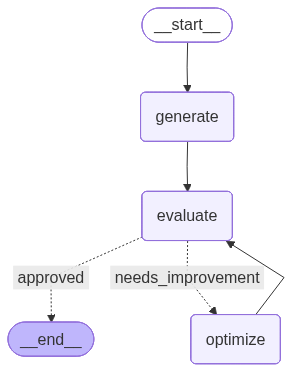

In [13]:
graph = StateGraph(TweetState)

graph.add_node('generate', generate_tweet)
graph.add_node('evaluate', evaluate_tweet)
graph.add_node('optimize', optimize_tweet)

graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')

graph.add_conditional_edges('evaluate', route_evaluation, {'approved': END, 'needs_improvement': 'optimize'})
graph.add_edge('optimize', 'evaluate')

workflow = graph.compile()

workflow



In [14]:
initial_state = {
    "topic": "srhberhb",
    "iteration": 1,
    "max_iteration": 5
}
result = workflow.invoke(initial_state)

In [15]:
result

{'topic': 'srhberhb',
 'tweet': "Here are a few options that address the feedback:\n\n**Option 1 (Focus on absurd cat ambition):**\nMy cat just typed 'srhberhb'. I'm pretty sure he's trying to hack the mainframe, not my password.\n\n**Option 2 (Focus on cat's 'master plan'):**\nMy cat just created 'srhberhb'. He's either demanding food in ancient code or planning world domination.\n\n**Option 3 (Focus on human struggle with the 'unhackable'):**\nMy cat generated 'srhberhb' as my new password. Unhackable? Yes. Unforgettable? Also yes. Thanks, Mittens.",
 'evaluation': 'approved',
 'feedback': "Option 1 successfully navigates the strict character limit while delivering a concise, original twist on a common cat trope. The humor derived from the cat's supposed ambition to hack the mainframe rather than a simple password is unexpected and sharp, making it genuinely chuckle-worthy and highly shareable among cat owners and tech enthusiasts. Its punchiness ensures it's scroll-stopping, and the

In [16]:
for tweet in result['tweet_history']:
    print(tweet)

My cat just walked across the keyboard. New password: srhberhb. Unhackable.
Here are a few options that address the feedback:

**Option 1 (Focus on absurd cat ambition):**
My cat just typed 'srhberhb'. I'm pretty sure he's trying to hack the mainframe, not my password.

**Option 2 (Focus on cat's 'master plan'):**
My cat just created 'srhberhb'. He's either demanding food in ancient code or planning world domination.

**Option 3 (Focus on human struggle with the 'unhackable'):**
My cat generated 'srhberhb' as my new password. Unhackable? Yes. Unforgettable? Also yes. Thanks, Mittens.
